# UniversityHack 2021 - Atmira Stock Prediction - Script Exploración

----
## Objectivo

Predecir las ventas online de PcComponentes para cada producto y día, con el fin de minimizar su espacio de almacenamiento pero a la vez intentando tener siempre disponibles los productos necesarios para poder evitar la rotura de stock. 

En particular, el objetivo principal es minimizar la métrica:

$$
\text{Métrica} = 0.7 \; \left( \frac{1}{\bar{y}} \sqrt{\frac{\sum_{i=1}^n \left(y_i - \hat{y}_i \right)^2}{n}} \, \right) + 0.3 \left( 1-CF  \right)
$$

donde $y_i$ son las ventas reales,  $\hat{y}_i$ las estimaciones de las ventas, $n$ el número de casos, $\bar{y}$ es la media de las ventas reales, y CF es el porcentaje de casos favorables en los que no ha habido rotura.


<a name="Indice">
    
----
# Índice de contenidos
    
1. [**Exploración datos**](#Exploracion)
    1. Resumen de las observaciones
    2. Ficheros
    3. Entradas duplicadas
    4. Observaciones más destacables de las variables 
    5. Relaciones entre variables  
    
    
2. [**Análisis temporal y estacional**](#SeriesTemporales)  
    1. Análisis temporal y **corrección de la fecha** en los datos
    2. Series temporales y periodicidad


In [10]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import datetime

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

<a name="Exploracion">

----
# 1. Exploración datos

## Resumen de las observaciones

#### Tratamiento de Datos
* Los datos de entrenamiento han sido alterados de múltiples maneras y de forma inhomogénea, lo cuál da un grado imporante de ambigüedad al problema, ya que no está claro cuál de los patrones seguirán los datos a predecir.
* Las fechas de los datos són erróneas, las observaciones no corresponden a los años 2015-2016 sino a 2018-2019. Esto es crucial ya que el año 2016 fue bisiesto y tener un día más generaba patrones diferentes de comportamiento desfasados en función del día de la semana.
* La variable "visitas" del fichero "Modelar" ha sido multiplicada por 5 pero sólo a partir del 25 de enero. La del fichero "Estimar" también.
* La variable "unidades_vendidas" del fichero "Modelar" ha sido multiplicada por un factor 3.
* La variable "antiguedad" no cambia con el tiempo, es una característica estática de los productos. Es decir, los productos no envejecen un día después que haya pasado un día. Además, no tienen el mismo valor para los dos ficheros, tienen un desfase.

#### Análisis Exploratoria de Datos
* Los fines de semana y los festivos no asociados a compra de regalos muestran una disminución de las visitas y las ventas.
* Hay una correlación significativa entre el día de la semana y las ventas.
* Los datos tienen una fuerte periodicidad semanal a la que se le suman picos i mínimos ocasionales.
* Los clientes tienen más tendencia a visitar y no comprar los fines de semana.
  


## Ficheros

Tenemos dos ficheros con 10 variables comunes: fecha, id, visitas, categoria_uno, categoria_dos, estado, precio,  dia_atipico, campaña, y antiguedad.

* **Modelar_UH2021.txt**  
    * Datos comprendidos entre el 01/06/2015 y el 30/09/2016 (487 días)
    * Tiene una entrada para cada producto y día del intervalo
    * Incluye la variable *unidades_vendidas* con las ventas por producto y día, la variable a predecir
    * Usaremos estos datos para entrenar y validar el modelo  
    
    
* **Estimar2.txt** 
    * Datos comprendidos entre el 01/10/2016 y el 31/12/2016 (92 días)
    * Tiene menos productos y los que hay no tienen una entrada para todos los días del intervalo
    * No incluye la variable *unidades_vendidas*
    * Estos son los productos y días de los que debemos estimar las ventas
    
Los dos ficheros tienen estructuras diferentes, así que parte del procesamiento de datos consisistirá en uniformizarlos. 

In [473]:
df = pd.read_csv('./data/Modelar_UH2021.txt', sep="|", decimal=",", parse_dates=[0], dayfirst=True, 
                 dtype = {4: 'object', 6: 'float', 9: 'Int64'} )

In [474]:
df_est = pd.read_csv( './data/Estimar2.txt', sep="|", decimal=",", parse_dates=[0], 
                     dtype = {4: 'object', 6: 'float', 9: 'Int64'} )

In [371]:
# Descripción estadística de las variables numéricas de los datos de Modelar y de Estimar
display(df.describe())
display(df_est.describe())

,id,visitas,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
count,4.045022e+06,4.045022e+06,1.402111e+06,4.045022e+06,4.045022e+06,3.170857e+06,4.045022e+06
mean,2.745180e+05,1.721371e+02,3.424319e+01,6.365503e-02,2.801715e-03,1.011114e+03,4.693434e+00
std,8.336719e+04,6.889116e+02,2.330943e+01,3.597475e-01,5.285704e-02,7.162509e+02,2.237403e+01
min,2.197200e+04,0.000000e+00,3.570000e+00,-1.000000e+00,0.000000e+00,1.260000e+02,0.000000e+00
25%,2.122940e+05,7.000000e+00,1.652000e+01,0.000000e+00,0.000000e+00,5.240000e+02,0.000000e+00
50%,2.926720e+05,3.500000e+01,2.689000e+01,0.000000e+00,0.000000e+00,7.950000e+02,0.000000e+00
75%,3.379000e+05,1.300000e+02,4.535000e+01,0.000000e+00,0.000000e+00,1.244000e+03,3.000000e+00
max,4.586600e+05,1.200450e+05,1.757800e+02,1.000000e+00,1.000000e+00,5.310000e+03,4.881000e+03


,id,visitas,precio,dia_atipico,campaña,antiguedad
count,212841.000000,212841.000000,212841.000000,212841.000000,212841.000000,212841.000000
mean,254764.373124,305.879624,26.928288,0.277837,0.014471,1059.632839
std,97368.478179,1534.355917,21.127655,0.517923,0.119422,844.078251
min,21972.000000,0.000000,0.000000,-1.000000,0.000000,35.000000
25%,177232.000000,25.000000,12.170000,0.000000,0.000000,449.000000
50%,264804.000000,75.000000,19.440000,0.000000,0.000000,826.000000
75%,335178.000000,225.000000,35.720000,1.000000,0.000000,1462.000000
max,458660.000000,289620.000000,141.180000,1.000000,1.000000,5219.000000




## Entradas duplicadas
Los datos deberían tener una sola entrada por producto para cada día, pero en el caso de los datos de Modelar hay un gran número de entradas duplicadas. En particular, hay entradas duplicadas para el mismo día y producto pero con valores diferentes en las variables "campaña" (0 y 1) y "antigüedad" (en este último caso, alternando entre la antigüedad y NaN).

In [475]:
df = df.drop_duplicates().sort_values(["id", "fecha", "campaña"])
df[(df.fecha == datetime.datetime(2015,11,18)) & (df.id == 260338)]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
1414953,2015-11-18,260338,593,A,46,No Rotura,22.23,0,0,946,15
1414965,2015-11-18,260338,593,A,46,No Rotura,22.23,0,0,<NA>,15
1414952,2015-11-18,260338,593,A,46,No Rotura,22.23,0,1,946,15
1414964,2015-11-18,260338,593,A,46,No Rotura,22.23,0,1,<NA>,15


Para resolverlo, ordenamos las entradas por producto, fecha, campaña y antigüedad, y dejamos sólo la última entrada.

In [476]:
df = df.drop_duplicates(subset=["id", "fecha", "antiguedad"], keep="last")
indexs_to_drop = df[(df.duplicated(subset=["id", "fecha"], keep=False)) & df.antiguedad.isnull()].index
df = df.drop(indexs_to_drop)

In [374]:
df[(df.fecha == datetime.datetime(2015,11,18)) & (df.id == 260338)]

,fecha,id,visitas,categoria_uno,categoria_dos,estado,precio,dia_atipico,campaña,antiguedad,unidades_vendidas
1414952,2015-11-18,260338,593,A,46,No Rotura,22.23,0,1,946,15



## Fecha

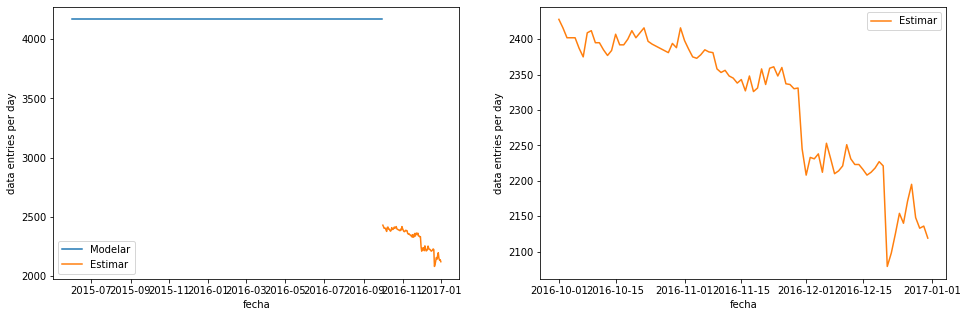

In [376]:
# Agrupamos entradas por fecha para el recuento
df_entradas_dia = df.groupby("fecha").count()
df_est_entradas_dia = df_est.groupby(["fecha"]).count()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,5])
axs[0].plot(df_entradas_dia.index, df_entradas_dia["id"])
axs[0].plot(df_est_entradas_dia.index, df_est_entradas_dia["id"])
axs[0].set(xlabel= "fecha", ylabel="data entries per day")
axs[0].legend(["Modelar", "Estimar"])

axs[1].plot(df_est_entradas_dia.index, df_est_entradas_dia["id"], color="tab:orange")
axs[1].set(xlabel= "fecha", ylabel="data entries per day")
axs[1].legend(["Estimar"])

#### Observaciones 
* El archivo Modelar tiene muchas más entradas por día que el archivo Estimar
* El archivo Modelar tiene un número constante de entradas cada día (4168).
* El archivo Estimar tiene un número irregular de entradas por día (2079-2428), con tendencia a disminuir con el tiempo.

## Id

In [477]:
print('Productos en "Modelar": ', len(df.id.unique()) )     # 4168
print('Productos en "Estimar": ', len(df_est.id.unique()), "\n" )  # 2736

print('Productos en "Modelar" que no aparecen en "Estimar": ', 
      len(np.setdiff1d(df.id.unique(),df_est.id.unique())))
print('Productos en "Estimar" que no aparecen en "Modelar": ', 
      len(np.setdiff1d(df_est.id.unique(),df.id.unique())))

Productos en "Modelar":  4168
Productos en "Estimar":  2736 

Productos en "Modelar" que no aparecen en "Estimar":  1432
Productos en "Estimar" que no aparecen en "Modelar":  0


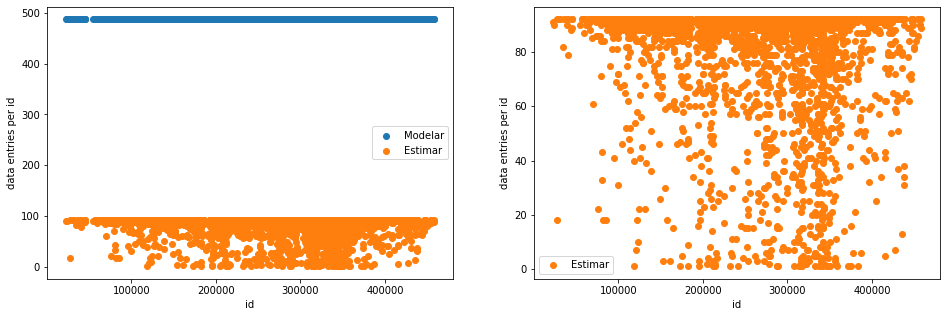

In [378]:
# Agrupamos entradas por id para el recuento
df_entradas_id = df.groupby("id").count()
df_est_entradas_id = df_est.groupby("id").count()

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[16,5])
axs[0].scatter(df_entradas_id.index, df_entradas_id["fecha"])
axs[0].scatter(df_est_entradas_id.index, df_est_entradas_id["fecha"])
axs[0].set(xlabel= "id", ylabel="data entries per id")
axs[0].legend(["Modelar", "Estimar"])

axs[1].scatter(df_est_entradas_id.index, df_est_entradas_id["fecha"], color="tab:orange")
axs[1].set(xlabel= "id", ylabel="data entries per id")
axs[1].legend(["Estimar"])

#### Observaciones 
* El archivo Modelar tiene un número constante de entradas por producto (487)
* El archivo Estimar tiene un número irregular de entradas por producto (1-92)
* El archivo Modelar tiene 1,5 veces más productos que el archivo Estimar
* En el fichero Estimar hay un **subconjunto** de los productos que aparecen en el fichero Modelar

## Visitas

### Visitas en función de la fecha

In [478]:
# Agrupamos los datos por fecha
data_mean_total = df.groupby('fecha').mean().sort_values('fecha')
data_est_mean_total = df_est.groupby('fecha').mean().sort_values('fecha')

data_sum_total = df.groupby('fecha').sum().sort_values('fecha')
data_est_sum_total = df_est.groupby('fecha').sum().sort_values('fecha')

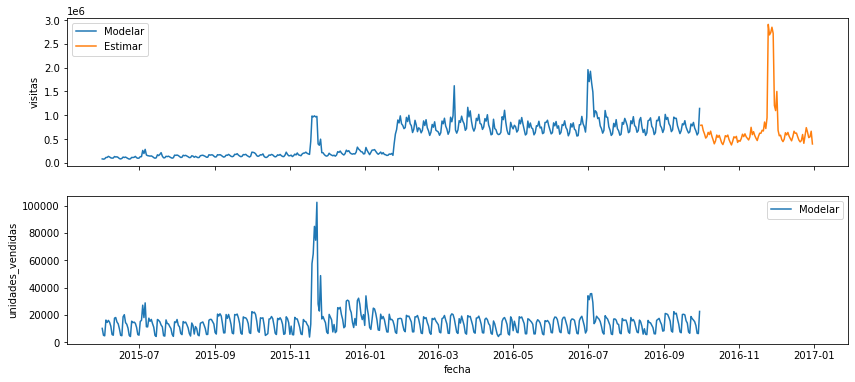

In [387]:
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=[14,6])

axs[0].plot(data_sum_total["visitas"])
axs[0].plot(data_est_sum_total["visitas"])
axs[0].set(ylabel="visitas")
axs[0].legend(["Modelar", "Estimar"])

axs[1].plot(data_sum_total["unidades_vendidas"])
axs[1].set(ylabel="unidades_vendidas", xlabel="fecha")
axs[1].legend(["Modelar"])

#### Observaciones
* Observamos un **salto en las visitas** anòmalo en los datos de entrenamiento entre el 24 y el 25 de enero que **NO se corresponde** con un **aumento de las ventas**.
* Además, según [esta referencia](https://sonitron.net/pccomponentes-pcdays-2019/), PcComponentes registraba una media de **350.000 visitas diarias** (en 2019), lo cuál está más acorde con el valor de antes del salto que con el valor de después del salto.

### Último dígito en el número de visitas

Analizamos el último dígito del número de la variable "visitas" antes y después del salto en las visitas para detectar posibles anomalías.

In [479]:
df["visitas_digito"] = df["visitas"] % 10
df_est["visitas_digito"] = df_est["visitas"] % 10

In [389]:
df_before = df[df.fecha <= datetime.datetime(2016,1,24)]
df_after = df[df.fecha > datetime.datetime(2016,1,24)]

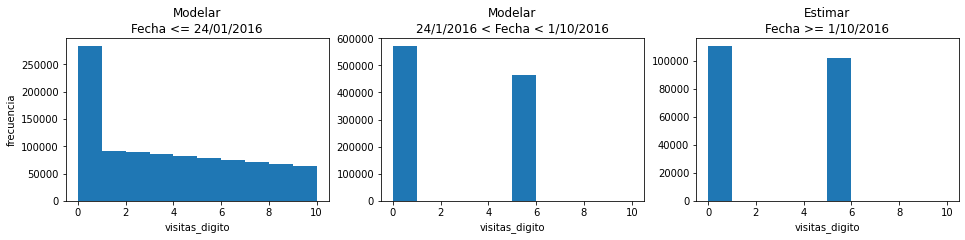

In [390]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=[16,3])
axs[0].set(xlabel="visitas_digito", ylabel="frecuencia", title="Modelar\nFecha <= 24/01/2016")
axs[1].set(xlabel="visitas_digito", title="Modelar\n24/1/2016 < Fecha < 1/10/2016")
axs[2].set(xlabel="visitas_digito", title="Estimar\nFecha >= 1/10/2016")

fig1 = axs[0].hist(df_before["visitas_digito"], bins=np.arange(0,11,1) ) 
fig2 = axs[1].hist(df_after["visitas_digito"], bins=np.arange(0,11,1))
fig2 = axs[2].hist(df_est["visitas_digito"], bins=np.arange(0,11,1))

In [604]:
df = df.drop(columns=["unidades_vendidas_digito"])

#### Observaciones 
* En el caso de los datos hasta el 24 de enero obtenemos la distribución esperada. Muchos productos que no han tenido ninguna visita contribuyen al 0 y el resto de dígitos disminuyen suavemente, debido a que es más probable que más productos tengan un número bajo de visitas.
* En el caso de los datos a partir del 24 de enero vemos con sorpresa una distribución con sólo dos valores, 0 y 5, tanto para los datos del fichero Modelar como los de Estimar. Pero que las visitas sean siempre **múltiples de cinco, NO es un comportamiento orgánico** de esta variable, e indica que las visitas **han sido multiplicadas** por ese valor.

In [480]:
# Generar columna con las visitas corregidas
df['visitas_scl'] = np.where( (df['fecha'] <= datetime.datetime(2019,1,24)), df['visitas']*5, df['visitas']*1)

### Resultados para una selección de productos top ventas después de la corrección

In [611]:
# For control and visualization purposes I select a few reference products with a large and constant sales volume
agrupacio_id_mitjanes = df.groupby("id")["unidades_vendidas"].mean()
agrupacio_id_std = df.groupby("id")["unidades_vendidas"].std()
agrupacio_id_std_rel = agrupacio_id_std/agrupacio_id_mitjanes
reference_products_id = (agrupacio_id_mitjanes[agrupacio_id_mitjanes > 50]
                         [agrupacio_id_mitjanes[agrupacio_id_mitjanes > 50].index
                          .isin(agrupacio_id_std_rel[agrupacio_id_std_rel < 1].index)])
reference_products_id

id
86096     104.519507
171826     85.521561
171840    121.977413
259970     53.950719
333946     50.599589
Name: unidades_vendidas, dtype: float64

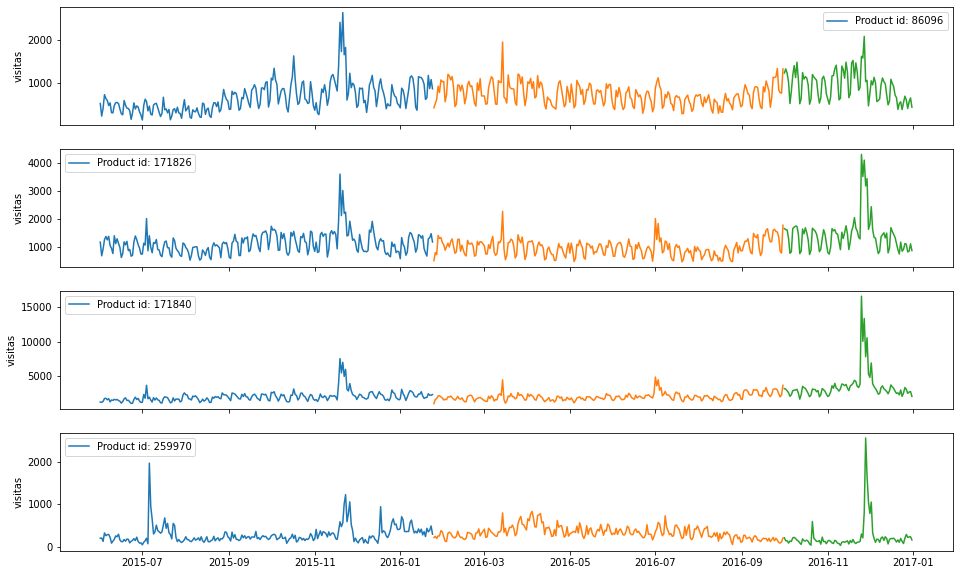

In [614]:
# Product 333946 is not in Estimar
fig, axs = plt.subplots(nrows=len(reference_products_id.index[:-1]), ncols=1, figsize=[16,10], sharex=True)
for i, idp in enumerate(reference_products_id.index[:-1]):
    axs[i].plot(df.loc[(df["id"] == idp) & (df.fecha <= datetime.datetime(2016,1,24)), ].fecha, 
                5*df.loc[(df["id"] == idp) & (df.fecha <= datetime.datetime(2016,1,24)), ].visitas)
    
    axs[i].plot(df.loc[(df["id"] == idp) & (df.fecha > datetime.datetime(2016,1,24)), ].fecha, 
                df.loc[(df["id"] == idp) & (df.fecha > datetime.datetime(2016,1,24)), ].visitas)
    axs[i].plot(df_est.loc[df_est["id"] == idp, ].fecha, df_est.loc[df_est["id"] == idp, ].visitas)
    axs[i].set(ylabel="visitas")
    axs[i].legend(["Product id: "+ str(idp)])

## Categorías uno y dos

In [481]:
# Número de entradas con categoría uno o dos ausentes
len(df[df["categoria_uno"].isnull()]), len(df[df["categoria_dos"].isnull()])

(0, 4383)

In [482]:
# Etiquetamos los valores ausentes de la categoria dos con un 0
df["categoria_dos"] = df["categoria_dos"].fillna("0").astype("int")

In [483]:
list_categoria_uno = sorted(df["categoria_uno"].unique())
print("Total categorías uno:", len(list_categoria_uno))
print("Total categorías dos:", len(df["categoria_dos"].unique()),)

Total categorías uno: 13
Total categorías dos: 183


### Productos en cada categoria uno

A: 1386
B:  106
C:  336
D:    1
E:  329
F:  574
G:  173
H:  407
I:   75
K:  656
L:  109
N:   16


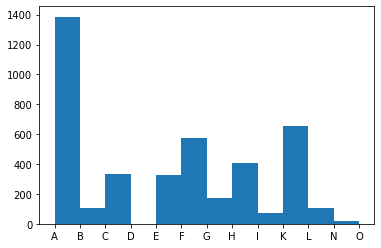

In [561]:
grupo_categorias = df.groupby(["id","categoria_uno"]).count().sort_values("categoria_uno")
items_in_categoria = plt.hist(grupo_categorias.reset_index()["categoria_uno"].values, bins=12)
#sorted(list(zip(sorted(df["categoria_uno"].unique()),items_in_categoria)))
for index, categoria in enumerate(sorted(df["categoria_uno"].unique())[:-1]):
    print(f"{categoria}: {items_in_categoria[0][index]:4.0f}")

### Categorías dos en cada categoria uno

In [562]:
suma_categories = 0
for index in range(len(df["categoria_uno"].unique())):
    print("\nCategoria uno", list_categoria_uno[index], "\nNúmero de categorias dos:", 
          len(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique()))
    print( list(sorted(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique() ) ))
    suma_categories += len(df["categoria_dos"][df["categoria_uno"] == list_categoria_uno[index]].unique())

print("\nSuma de categorías dos: ", suma_categories)


Categoria uno A 
Número de categorias dos: 35
[0, 16, 23, 28, 34, 37, 43, 46, 67, 69, 82, 85, 103, 127, 133, 137, 145, 188, 197, 201, 236, 237, 238, 242, 245, 255, 263, 271, 282, 286, 295, 304, 338, 342, 343]

Categoria uno B 
Número de categorias dos: 5
[57, 92, 153, 224, 312]

Categoria uno C 
Número de categorias dos: 12
[63, 65, 66, 72, 73, 75, 76, 157, 158, 160, 161, 170]

Categoria uno D 
Número de categorias dos: 1
[264]

Categoria uno E 
Número de categorias dos: 57
[0, 10, 22, 30, 32, 44, 49, 50, 51, 78, 80, 93, 105, 108, 109, 114, 115, 122, 124, 125, 135, 143, 144, 150, 152, 156, 171, 175, 179, 186, 199, 200, 202, 205, 216, 229, 230, 233, 247, 248, 249, 266, 267, 268, 269, 273, 274, 275, 276, 277, 285, 305, 308, 314, 315, 319, 323]

Categoria uno F 
Número de categorias dos: 9
[0, 20, 97, 203, 217, 228, 333, 336, 341]

Categoria uno G 
Número de categorias dos: 11
[29, 39, 42, 123, 155, 207, 221, 235, 253, 270, 298]

Categoria uno H 
Número de categorias dos: 24
[0, 2, 38, 4

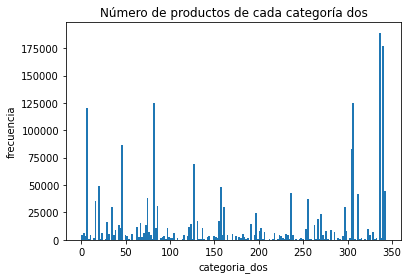

In [563]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[6,4])

axs.hist(df.dropna(subset=["categoria_dos"])["categoria_dos"], bins=182)
tal = axs.set(xlabel="categoria_dos", ylabel="frecuencia", title="Número de productos de cada categoría dos")

## Estado

En el fichero Estimar no hay ninguna observación con el stock en estado de "Rotura":

In [569]:
print("Fichero Modelar:", df.estado.unique())
print("Fichero Estimar:", df_est.estado.unique())

Fichero Modelar: ['No Rotura' 'Rotura' 'Transito']
Fichero Estimar: ['No Rotura' 'Transito']


## Precio

En el fichero Modelar hay muchos valores ausentes en la variable precio. Cuando el valor del precio en una entrada es nulo, ha de ser completado con el precio anterior temporalmente más cercano de ese artículo.

In [595]:
# Número de entradas con el precio NaN en el fichero modelar
print(f"{df.precio.isnull().sum()} de {len(df)}  ({100*df.precio.isnull().sum()/len(df):.2f} %)")

1397989 de 2029816  (68.87 %)


In [ ]:
# Forwardfill del precio i eliminarción de los valores vacíos del principio
from IPython.display import clear_output

df_fill = df.copy()
total = len(df.id.unique())

for i, pid in enumerate(df.id.unique()):
    # This product's entries
    df_prod = df[df.id == pid]
    
    # Fillforward, then back to cover the first few lines
    df_prod = df_prod.fillna(method='ffill').fillna(method='bfill')

    # Save to DF
    df_fill.loc[df_prod.index] = df_prod
    
    clear_output(wait=True)
    print("Filled %.1f%% of the Dataframe" % (i/total * 100))

In [ ]:
df_fill.to_csv('./data/Modelar_UH2021_filled_precio.txt')

## Antigüedad

En el fichero Modelar hay muchos valores ausentes en la variable antigüedad:

In [593]:
# Número de entradas con la antiguedad NaN en el fichero modelar
print(f"{df.antiguedad.isnull().sum()} de {len(df)}  ({100*df.antiguedad.isnull().sum()/len(df):.2f} %)")

477260 de 2029816  (23.51 %)


Debido al gran número de valores ausentes en esta variable, y que no hemos encontrado mejora al incluirla en los modelos, la hemos eliminado de los datos.

## Unidades vendidas

### Último dígito en el número de unidades vendidas

También analizamos la variable "unidades vendidas" mediante la operación modulo para detectar posibles anomalías (esta variable no se encuentra en el archivo "Estimar" porque es la que hay que predecir).

In [598]:
df["unidades_vendidas_digito"] = df["unidades_vendidas"] % 10
df["unidades_vendidas_modulo_3"] = (df["unidades_vendidas"]) % 3

In [599]:
df_before = df[df.fecha <= datetime.datetime(2016,1,24)]
df_after = df[df.fecha > datetime.datetime(2016,1,24)]

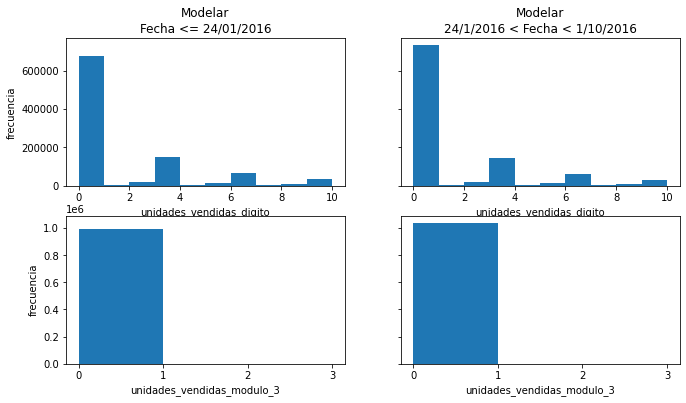

In [600]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[11,6], sharey="row")

axs[0,0].set(xlabel="unidades_vendidas_digito", ylabel="frecuencia", title="Modelar\nFecha <= 24/01/2016")
axs[0,1].set(xlabel="unidades_vendidas_digito", title="Modelar\n24/1/2016 < Fecha < 1/10/2016")
axs[1,0].set(xlabel="unidades_vendidas_modulo_3", ylabel="frecuencia")
axs[1,0].xaxis.set_major_locator(MaxNLocator(integer=True))
axs[1,1].set(xlabel="unidades_vendidas_modulo_3")
axs[1,1].xaxis.set_major_locator(MaxNLocator(integer=True))

fig1 = axs[0,0].hist(df_before["unidades_vendidas_digito"], bins=np.arange(0,11,1))
fig2 = axs[0,1].hist(df_after["unidades_vendidas_digito"], bins=np.arange(0,11,1))
fig3 = axs[1,0].hist(df_before["unidades_vendidas_modulo_3"], bins=np.arange(0,4,1))
fig3 = axs[1,1].hist(df_after["unidades_vendidas_modulo_3"], bins=np.arange(0,4,1))

In [605]:
df = df.drop(columns=["unidades_vendidas_modulo_3"])

#### Observaciones 
* Tanto en los datos anteriores como los posteriores al 25 de enero encontramos una distribución también anómala. Como antes, muchos productos que no han tenido ninguna visita contribuyen al 0 pero el resto de dígitos están distribuidos de forma irregular.
* Si hacemos hacemos el módulo 3 de la variable "unidades vendidas", vemos que todos los datos dan 0. Pero que las ventas para cualquier producto sean siempre **múltiples de tres NO es un comportamiento orgánico** de esta variable e indica que las unidades vendidas **han sido multiplicadas** por ese valor.

<a name="Correlaciones">

## Relación entre variables

### Distribuciones de parejas de variables

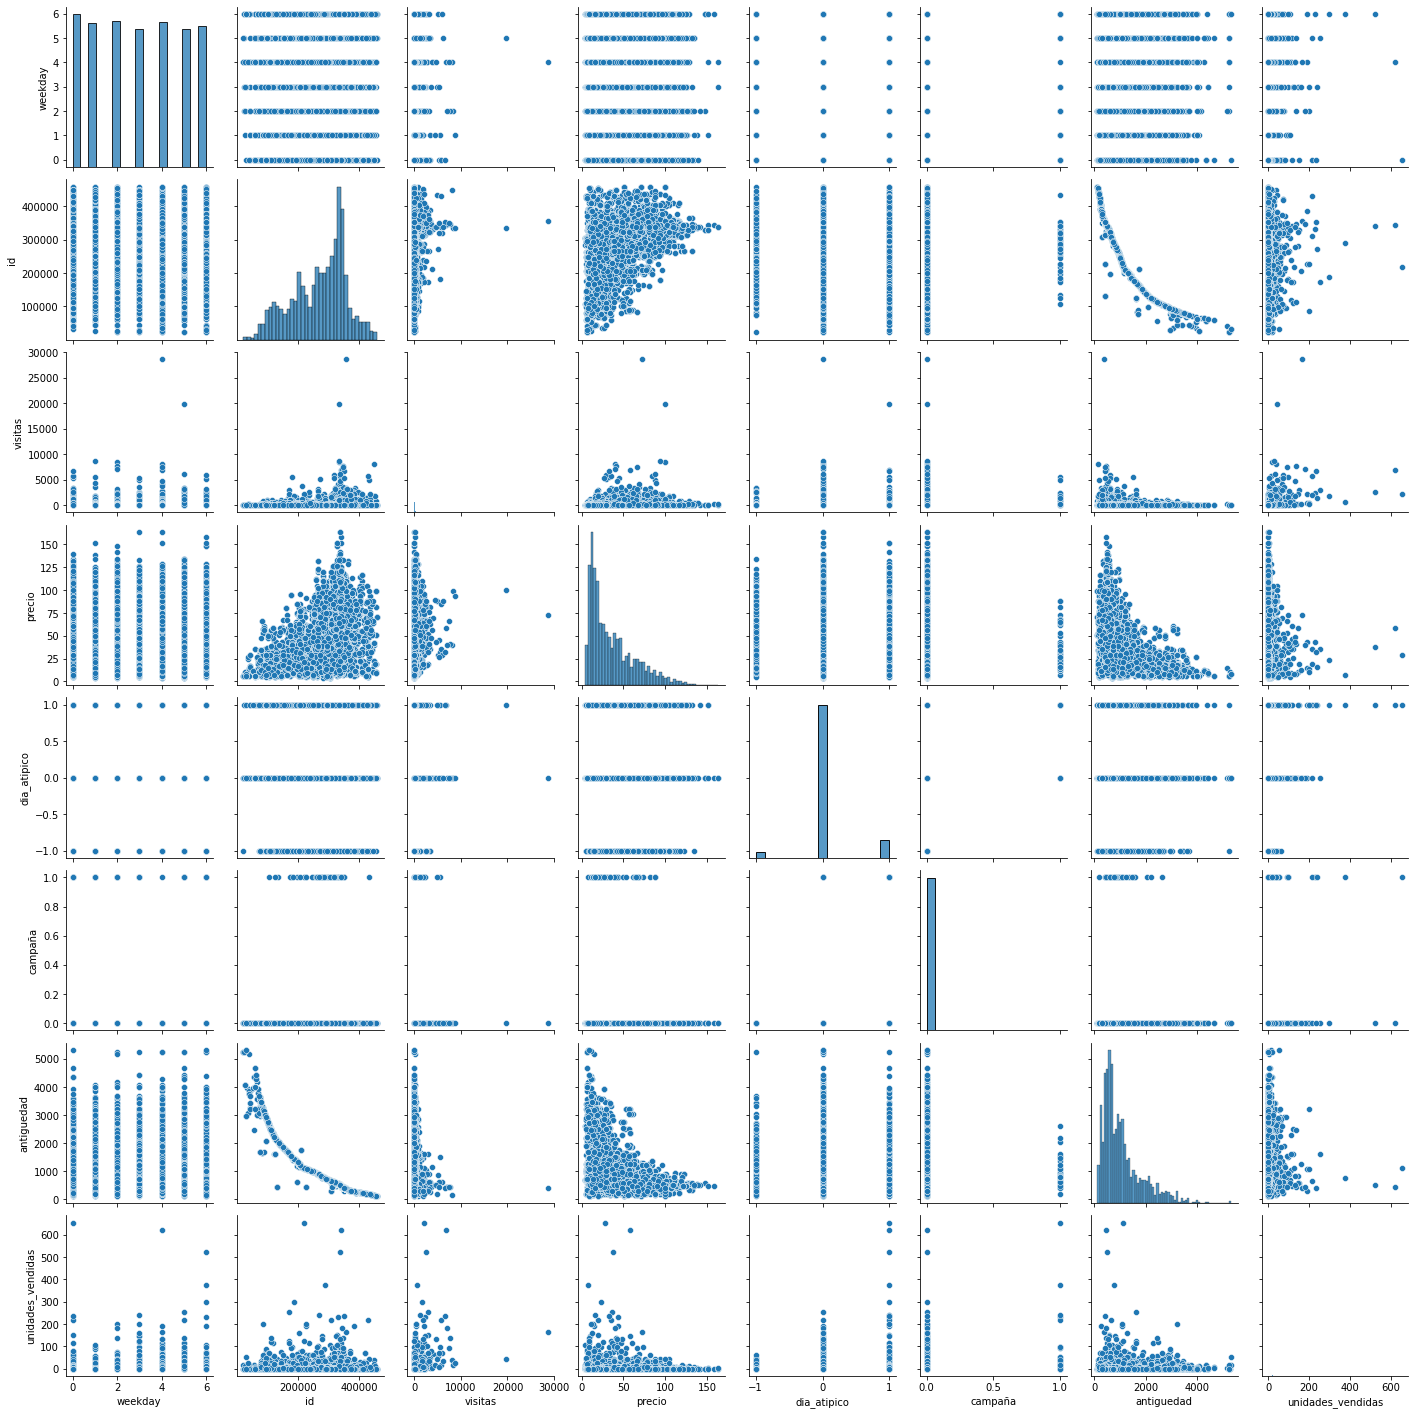

In [10]:
sns.pairplot(df.loc[:, ["weekday", "id", "visitas", "estado", "precio", "dia_atipico", "campaña", "antiguedad", 
                     "unidades_vendidas"]].sample(n=10000))

### Correlaciones entre variables

Aparte de las magnitudes ya esperables, hay una gran correlación entre la variable "id" y la variable "antigüedad":

In [606]:
df.corr()

,id,visitas,categoria_dos,precio,dia_atipico,campaña,antiguedad,unidades_vendidas,visitas_digito,visitas_scl
id,1.000000e+00,0.085286,2.118712e-01,0.408736,-7.699430e-15,0.010973,-9.378170e-01,-0.035457,-0.176079,0.085286
visitas,8.528608e-02,1.000000,9.031541e-02,0.227330,4.039967e-03,0.151288,-7.248772e-02,0.394339,0.003878,1.000000
categoria_dos,2.118712e-01,0.090315,1.000000e+00,0.487407,-1.710478e-15,0.015836,-1.388814e-01,0.008278,-0.036304,0.090315
precio,4.087362e-01,0.227330,4.874073e-01,1.000000,-3.620632e-03,0.048561,-3.534176e-01,-0.020050,0.005808,0.227330
dia_atipico,-7.699430e-15,0.004040,-1.710478e-15,-0.003621,1.000000e+00,0.168468,5.520259e-15,0.061805,0.058378,0.004040
campaña,1.097282e-02,0.151288,1.583553e-02,0.048561,1.684676e-01,1.000000,-1.336865e-02,0.199077,0.024622,0.151288
antiguedad,-9.378170e-01,-0.072488,-1.388814e-01,-0.353418,5.520259e-15,-0.013369,1.000000e+00,0.038830,0.134389,-0.072488
unidades_vendidas,-3.545675e-02,0.394339,8.277546e-03,-0.020050,6.180497e-02,0.199077,3.882975e-02,1.000000,0.052438,0.394339
visitas_digito,-1.760792e-01,0.003878,-3.630442e-02,0.005808,5.837779e-02,0.024622,1.343886e-01,0.052438,1.000000,0.003878
visitas_scl,8.528608e-02,1.000000,9.031541e-02,0.227330,4.039967e-03,0.151288,-7.248772e-02,0.394339,0.003878,1.000000


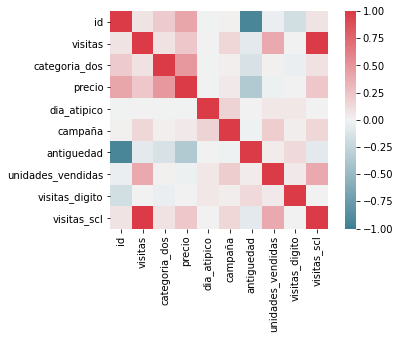

In [609]:
colormap = sns.diverging_palette(220, 10, as_cmap=True)
axis_corr = sns.heatmap( df.corr(), vmin=-1, vmax=1, center=0, square=True, cmap=colormap)
plt.show()

<a name="VvsV">

### Unidades vendidas vs Visitas

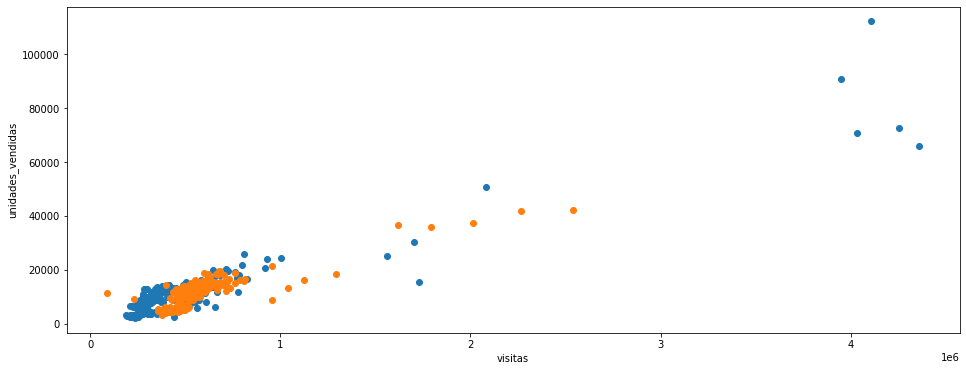

In [48]:
plt.figure(figsize=[16,6])
plt.scatter(group_dates_red_sum.loc[:datetime.datetime(2019,1,24)]["visitas"]*5, 
            group_dates_red_sum.loc[:datetime.datetime(2019,1,24)]["unidades_vendidas"])
plt.scatter(group_dates_red_sum.loc[datetime.datetime(2019,1,24):]["visitas"], 
            group_dates_red_sum.loc[datetime.datetime(2019,1,24):]["unidades_vendidas"])

labx = plt.xlabel("visitas")
laby = plt.ylabel("unidades_vendidas")

#### [Índice](#Indice)
<a name="SeriesTemporales">

----
# 3. Análisis temporal y estacional
   

 
## Análisis temporal y **corrección de la fecha** en los datos
    
Uno de los descubrimientos más importantes en la exploración de datos ha sido que **los años en las fechas de los datos eran incorrectos. No eran datos del 2015-2016 sinó del 2018-2019.** A continuación presentamos los argumentos y análisis que apoyan esta tesis y que nos han llevado a esta deducción.

### Visitas y ventas en función del día de la semana

Para explorar el comportamiento en función del día de la semana, **descartaremos los datos correspondientes a días especiales** en los que haya campañas publicitarias o en los que haya más o menos ventas de lo habitual, ya que podrían introducir sesgos importantes.

In [21]:
weekday_before_mean = df_before[(df_before["dia_atipico"] == 0) &
                                (df_before["campaña"] == 0)].groupby('weekday').mean().sort_values('weekday')
weekday_after_mean = df_after[(df_after["dia_atipico"] == 0) & 
                              (df_after["campaña"] == 0)].groupby('weekday').mean().sort_values('weekday')
weekday_estimar_mean = df_est[(df_est["dia_atipico"] == 0) & 
                              (df_est["campaña"] == 0)].groupby('weekday').mean().sort_values('weekday')

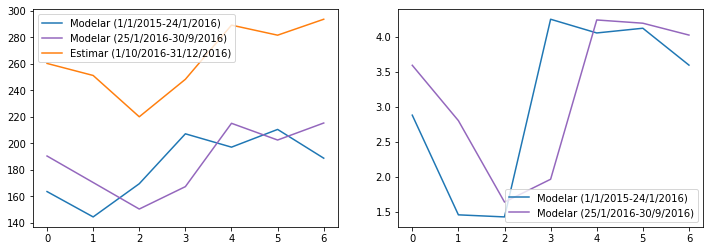

In [22]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[12,4])

axs[0].plot(5*weekday_before_mean["visitas"], color="tab:blue")
axs[0].plot(weekday_after_mean["visitas"], color="tab:purple")
axs[0].plot(weekday_estimar_mean["visitas"]*1.1, color = "tab:orange")
axs[0].legend(["Modelar (1/1/2015-24/1/2016)", "Modelar (25/1/2016-30/9/2016)", "Estimar (1/10/2016-31/12/2016)"])

axs[1].plot(weekday_before_mean["unidades_vendidas"], color="tab:blue")
axs[1].plot(weekday_after_mean["unidades_vendidas"], color="tab:purple")
axs[1].legend(["Modelar (1/1/2015-24/1/2016)", "Modelar (25/1/2016-30/9/2016)"])

#### Observaciones 
* Pueden observarse **dos comportamientos diferenciados** del volumen de visitas y de ventas en función del día de la semana segun el rango de fechas.
* Los dos comportamientos tienen el mismo perfil excepto por el **desfase de un dia**, lo cual no tiene sentido y claramente se trata de un error.

<a name="BF">

### Análisis de la campaña del Black Friday

Para determinar el día de la semana real y corregir los datos, **hemos usado la campaña del Black Friday** que realiza PcComponentes cada año. Según los artículos consultados, la campaña empieza el lunes antes del Black Friday, dura toda la semana con ofertas en diferentes tipos de productos, y termina el lunes siguiente con el Cyber Monday.

| .        .  | 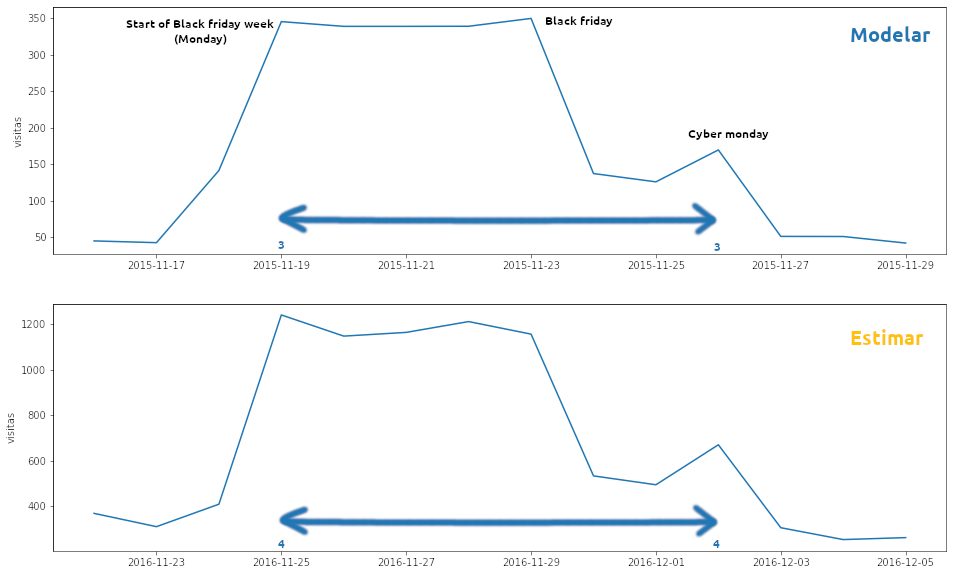  | .         .  |
| - | - | -  |

In [23]:
# Días del mes de febrero en el fichero de datos "Modelar"
data_mean_total[data_mean_total["month"] == 2]["day"].nunique()

28

#### Observaciones

* Hemos podido determinar la fecha del Black Friday en los datos observando tanto los picos de visitas como la duración de la variable "campaña" (indicada con la flecha horizontal). Según las fechas en el archivo "Modelar" el Black Friday habría sido el 23/11/2015 y en el caso del archivo "Estimar" sería el 29/11/2016. El problema es que **el 23/11/2015 fue un lunes y el 29/11/2016 fue un martes, no viernes!!** 

* Según las referencias históricas, el 2015 y 2016 el Black Friday tuvo lugar [el 27 y 25 de noviembre](https://www.timeanddate.com/holidays/us/black-friday) respectivamente, y las campañas del Black Friday de PcComponentes fueron del [23 al 30](https://computerhoy.com/noticias/hardware/pccomponentes-anuncia-su-black-friday-2015-36947) y del [21 al 28 de noviembre](https://www.eleconomista.es/tecnologia/noticias/7945821/11/16/PcComponentes-detalla-su-Black-Friday-una-semana-completa-de-ofertas.html) así que **las fechas de los datos estan equivocadas**.

* Además, el mes de febrero que aparece en el fichero "Modelar" **sólo tiene 28 días** y el **[2016 fue un año bisiesto](https://miniwebtool.com/es/leap-years-list/)**, lo que también confirma que **los años de las fechas son erróneas**.

* Sobre las fechas reales de los datos, tanto en los años **2018-2019** como **2012-2013 [sí que tuvieron el Black Friday el 23 y 29 de noviembre](https://www.timeanddate.com/holidays/us/black-friday)**, como aparece en los datos.

* Que los años de los datasets no correspondan con las fechas reales de los datos **explica el desfase de un día en el comportamiento** en función del día de la semana observado, ya que siendo **2016 un año bisiesto** tenía un día más y ni el 2013 ni el 2019 lo fueron.

<a name="Semana_Santa">

### Análisis de las visitas de Semana Santa

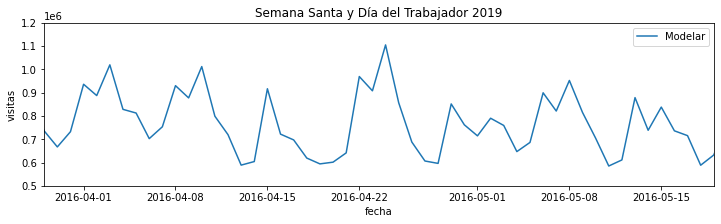

In [24]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[12,3])
axs.plot(data_sum_total["visitas"])
axs.set(xlim = (datetime.datetime(2016, 3, 29), datetime.datetime(2016, 5, 19)), ylim=(0.5e6,1.2e6),  
           xlabel="fecha", ylabel="visitas", title="Semana Santa y Día del Trabajador 2019")
axs.legend(["Modelar"])

#### Observaciones
* En 2019 la **Semana Santa** fue [del 14 al 21 de abril](https://calendarios.ideal.es/semana-santa/2019). Estas fechas coinciden con una **disminución de visitas y ventas** en los datos, que es algo que suele pasar en días festivos no asociados a hacer regalos, apoyando la tesis que **los datos corresponden al 2018-2019**. También puede observarse en la gráfica la disminución correspondiente al festivo del 1 de mayo.

<a name="PCdays">

### Análisis de la campaña de verano PcDays

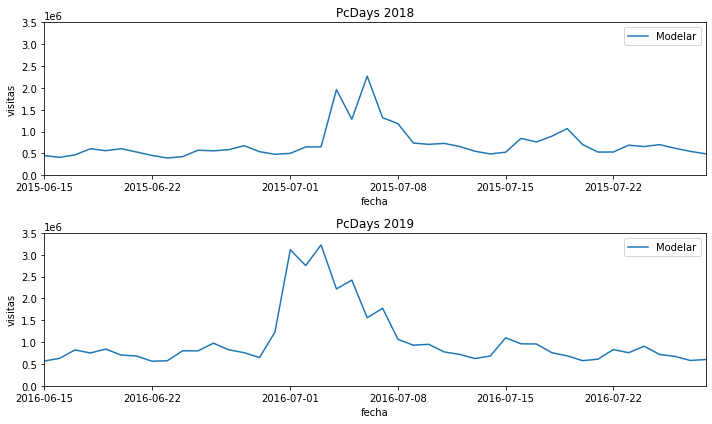

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=[10,6], sharey="row")

axs[0].plot(data_sum_total["visitas"]*5)
axs[0].set(xlim = (datetime.datetime(2015, 6, 15), datetime.datetime(2015, 7, 28)),  ylim=(0,3.5e6), 
           xlabel="fecha", ylabel="visitas", title="PcDays 2018")
axs[0].legend(["Modelar"])

axs[1].plot(data_sum_total["visitas"])
axs[1].set(xlim = (datetime.datetime(2016, 6, 15), datetime.datetime(2016, 7, 28)),  ylim=(0,3.5e6), 
           xlabel="fecha", ylabel="visitas", title="PcDays 2019")
axs[1].legend(["Modelar"])
plt.tight_layout()

In [26]:
# Total de unidades vendidas durante la campaña de PCDays (en 2019)
print(data_sum_total[(data_sum_total.index >= datetime.datetime(2016, 6, 29)) & 
                     (data_sum_total.index <= datetime.datetime(2016, 7, 12))]["unidades_vendidas"].sum())

378774


#### Observaciones
* Según [su página web](https://www.pccomponentes.com/pcdays), PcComponentes celebra los PCDays, la campaña de julio, sólo desde el 2016, así que los datos **NO pueden corresponder al 2012-2013, ni tampoco al 2015-2016.**
* La campaña PcDays fue del [4 al 7 de julio en 2018](https://www.muycomputer.com/2018/07/04/pcdays-2018/) y del [30 de junio al 7 de julio en 2019](https://sonitron.net/pccomponentes-pcdays-2019/), lo cuál también coincide con el perfil de visitas de los datos.
* Según [esta otra referencia](https://sonitron.net/pccomponentes-pcdays-2019/), PcComponentes vendió 126.000 productos en su campaña PcDays del 2019. Esto es alrededor 3 veces menos de lo cantidad que se infiere de los datos del fichero "Modelar", lo cual refuerza la idea que la variable "unidades_vendidas" ha sido **multiplicada por 3.**

<a name="VV_semana_corregidas">

### Visitas y ventas en función del día de la semana (corrigiendo los años a 2018-2019)

In [ ]:
# Corregimos los años que aparecen en los datos por 2018-2019
df.loc[df.fecha.dt.year == 2015, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2018)
df.loc[df.fecha.dt.year == 2016, "fecha"] = df["fecha"] + pd.offsets.DateOffset(year=2019)
df_est.loc[df_est.fecha.dt.year == 2015, "fecha"] = df_est["fecha"] + pd.offsets.DateOffset(year=2018)
df_est.loc[df_est.fecha.dt.year == 2016, "fecha"] = df_est["fecha"] + pd.offsets.DateOffset(year=2019)

In [28]:
# Actualizamos el día de la semana
df["weekday"] = df["fecha"].dt.weekday
df_est["weekday"] = df_est["fecha"].dt.weekday

In [29]:
# Selecciono los datos de cada periodo
df_before_2018_2019 = df[df.fecha <= datetime.datetime(2019,1,24)]
df_after_2018_2019 = df[df.fecha > datetime.datetime(2019,1,24)]

# Agrupo los datos de "Modelar" en dos periodos y los de "Estimar" en otro
weekday_before_mean_2018_2019 = df_before_2018_2019[(df_before_2018_2019["dia_atipico"] == 0) &
                                               (df_before_2018_2019["campaña"] == 0)
                                              ].groupby('weekday').mean().sort_values('weekday')
weekday_after_mean_2018_2019 = df_after_2018_2019[(df_after_2018_2019["dia_atipico"] == 0) & 
                                             (df_after_2018_2019["campaña"] == 0)
                                            ].groupby('weekday').mean().sort_values('weekday')
weekday_est_mean_2018_2019 = df_est[(df_est["dia_atipico"] == 0) & (df_est["campaña"] == 0)
                                   ].groupby('weekday').mean().sort_values('weekday')

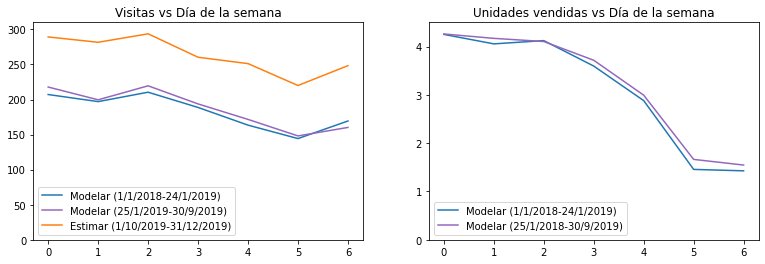

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=[13,4])

axs[0].plot(5*weekday_before_mean_2018_2019["visitas"], color="tab:blue")
axs[0].plot(weekday_after_mean_2018_2019["visitas"], color="tab:purple")
axs[0].plot(weekday_est_mean_2018_2019["visitas"]*1.1, color = "tab:orange")
axs[0].set(ylim=(0,310), title="Visitas vs Día de la semana")
axs[0].legend(["Modelar (1/1/2018-24/1/2019)", "Modelar (25/1/2019-30/9/2019)", "Estimar (1/10/2019-31/12/2019)"])

axs[1].plot(weekday_before_mean_2018_2019["unidades_vendidas"], color="tab:blue")
axs[1].plot(weekday_after_mean_2018_2019["unidades_vendidas"], color="tab:purple")
axs[1].set(ylim=(0,4.5), title="Unidades vendidas vs Día de la semana")
axs[1].yaxis.set_major_locator(MaxNLocator(integer=True))
axs[1].legend(["Modelar (1/1/2018-24/1/2019)", "Modelar (25/1/2018-30/9/2019)"])

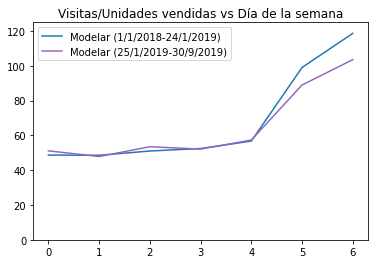

In [31]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=[6,4])

axs.plot(5*weekday_before_mean_2018_2019["visitas"]/
         weekday_before_mean_2018_2019["unidades_vendidas"], color="tab:blue")
axs.plot(weekday_after_mean_2018_2019["visitas"]/
         weekday_after_mean_2018_2019["unidades_vendidas"], color="tab:purple")
axs.set(ylim=(0,125), title="Visitas/Unidades vendidas vs Día de la semana")
axs.legend(["Modelar (1/1/2018-24/1/2019)", "Modelar (25/1/2019-30/9/2019)"])

#### Observaciones 
* Al corregir el año en las fechas no sólo **ha desaparecido el desfase de un día** de comportamiento entre diferentes periodos, sinó que además también tiene mucho más sentido interpretar los datos: éstos ya no tienen un comporamiento errático sino que se hace evidente que es **el fin de semana cuando caen las visitas y las ventas** (y no los miércoles, por ejemplo).
* La ratio entre visitas y compras es la misma los días entre semana, y **aumenta el sábado y el domingo**. Días en que los clientes visitan más frecuentemente las páginas de los productos sin comprarlos.
* Los clientes tienen más tendencia a visitar la página sin comprar el producto durante el fin de semana que entre semana.

## Series temporales y periodicidad

Hemos analizado la periodicidad y el carácter cíclico de los datos, tanto a corta como a más larga escala, así como también su comporamiento temporal usando conceptos de Series Temporales para extraer características clave  i variables nuevas para la predicción de Machine Learning. Nos interesa investigar la descomposicion estacional de los datos con la frecuencia de un día.

Esto de reflejará en una variación semanal de lunes a domigo para las *unidades_vendidas*, de la que insertaremos el valor en forma de variable neva para ayudar al modelo a entender que el día de la semana es de gran ayuda para la predicción de las ventas.

Addicionalment, también usaremos media mensual de la tendencia como una variable nueva para ayudar al modelo a incorporar todavía más esas variaciones entre diferentes meses del año.

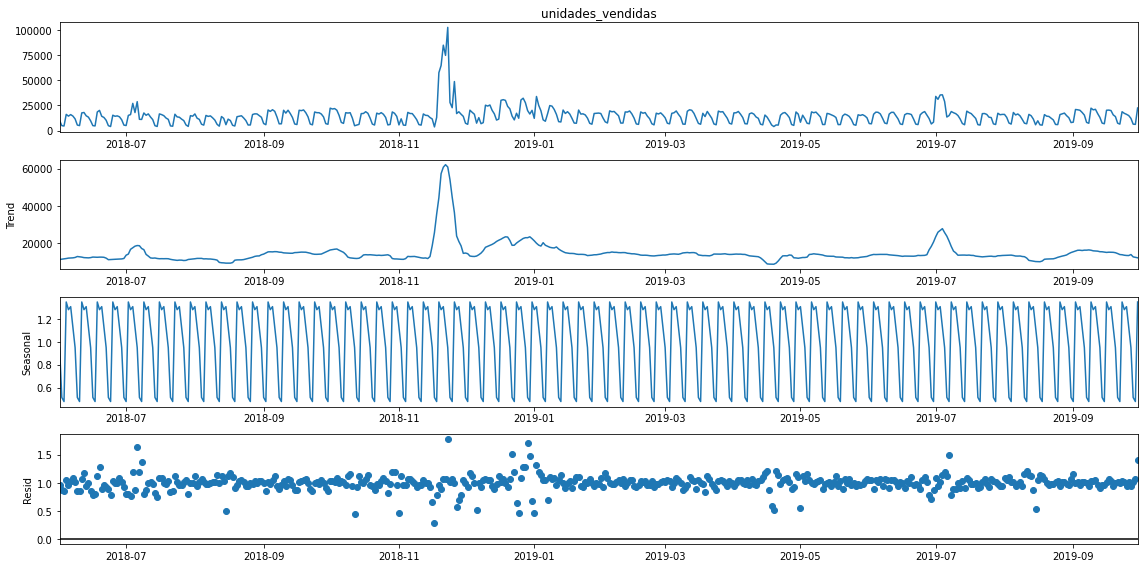

#### [Índice](#Indice)

---